In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shusrith_burgers_noisy_path = kagglehub.dataset_download('shusrith/burgers-noisy')

print('Data source import complete.')


100%|██████████| 1.25G/1.25G [00:18<00:00, 71.1MB/s]

Extracting files...


Data source import complete.


In [10]:
!find burgers

find: ‘burgers’: No such file or directory


In [11]:
shusrith_burgers_noisy_path

'/root/.cache/kagglehub/datasets/shusrith/burgers-noisy/versions/2'

In [2]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(
            self.base_weight, a=math.sqrt(5) * self.scale_base
        )
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(
                    self.spline_scaler, a=math.sqrt(5) * self.scale_spline
                )

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

In [3]:
class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [5]:
class KANWithDropout(torch.nn.Module):
    def __init__(self, layers_hidden, dropout_prob=0.3):
        super(KANWithDropout, self).__init__()
        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                nn.Sequential(
                    KANLinear(in_features, out_features),
                    nn.BatchNorm1d(out_features),
                    nn.SiLU(),
                    nn.Dropout(dropout_prob),
                )
            )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [14]:
import h5py
import numpy as np
with h5py.File("/root/.cache/kagglehub/datasets/shusrith/burgers-noisy/versions/2/simulation_data.h5", "r") as f:
    a = list(f.keys())
    clean = []
    noisy = []
    for i in a[:-1]:
        clean.append(f[i]["clean"][:])
        noisy.append(f[i]["noisy"][:])

clean = np.array(clean)
noisy = np.array(noisy)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import h5py
import numpy as np


print("Noisy data shape:", noisy.shape)

num_samples, height, width = noisy.shape
noisy_flattened = noisy.reshape(num_samples, -1)
clean_flattened = clean.reshape(num_samples, -1)

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()
        self.l1 = nn.L1Loss()

    def forward(self, output, target):
        return self.alpha * self.mse(output, target) + (1 - self.alpha) * self.l1(output, target)

X_tensor = torch.tensor(noisy_flattened, dtype=torch.float32)
Y_tensor = torch.tensor(clean_flattened, dtype=torch.float32)

dataset = TensorDataset(X_tensor, Y_tensor)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Trainloader size:", len(trainloader.dataset))
print("Testloader size:", len(testloader.dataset))

# Define the model with dropout and batch normalization


# Adjust the input dimensions to match the data
input_dim = noisy_flattened.shape[1]  # Flatten the input dimensions
model = KANWithDropout([input_dim, 512, 256, 128, 64, 128, 256, 512, input_dim])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Define ReduceLROnPlateau with patience and min_lr
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=True,
)

# Define loss
criterion = CombinedLoss()

# Training loop
for epoch in range(200):
    # Train
    model.train()
    with tqdm(trainloader) as pbar:
        for i, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            val_loss += criterion(output, targets).item()
    val_loss /= len(testloader)

    # Update learning rate
    scheduler.step(val_loss)

    print(f"Epoch {epoch + 1}, Val Loss: {val_loss}")

# Save the model
torch.save(model.state_dict(), "kan_model.pth")

Noisy data shape: (1000, 201, 1024)
Trainloader size: 800
Testloader size: 200


100%|██████████| 25/25 [00:02<00:00,  8.49it/s, loss=0.417, lr=0.001]


Epoch 1, Val Loss: 0.488453026328768


100%|██████████| 25/25 [00:02<00:00,  9.04it/s, loss=0.454, lr=0.001]


Epoch 2, Val Loss: 0.44547219361577717


100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=0.454, lr=0.001]


Epoch 3, Val Loss: 0.4440001845359802


100%|██████████| 25/25 [00:02<00:00,  8.86it/s, loss=0.387, lr=0.001]


Epoch 4, Val Loss: 0.41284662910870146


100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=0.388, lr=0.001]


Epoch 5, Val Loss: 0.39257316504205975


100%|██████████| 25/25 [00:02<00:00,  8.98it/s, loss=0.331, lr=0.001]


Epoch 6, Val Loss: 0.376366525888443


100%|██████████| 25/25 [00:02<00:00,  8.95it/s, loss=0.307, lr=0.001]


Epoch 7, Val Loss: 0.3646222310406821


100%|██████████| 25/25 [00:02<00:00,  8.86it/s, loss=0.285, lr=0.001]


Epoch 8, Val Loss: 0.3671943928514208


100%|██████████| 25/25 [00:02<00:00,  8.82it/s, loss=0.291, lr=0.001]


Epoch 9, Val Loss: 0.34625517044748577


100%|██████████| 25/25 [00:02<00:00,  8.89it/s, loss=0.29, lr=0.001] 


Epoch 10, Val Loss: 0.34775459340640474


100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=0.281, lr=0.001]


Epoch 11, Val Loss: 0.3486866865839277


100%|██████████| 25/25 [00:02<00:00,  8.98it/s, loss=0.247, lr=0.001]


Epoch 12, Val Loss: 0.3502537054674966


100%|██████████| 25/25 [00:02<00:00,  9.14it/s, loss=0.361, lr=0.001]


Epoch 13, Val Loss: 0.3333011908190591


100%|██████████| 25/25 [00:02<00:00,  8.88it/s, loss=0.355, lr=0.001]


Epoch 14, Val Loss: 0.3430355702127729


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.294, lr=0.001]


Epoch 15, Val Loss: 0.3391421139240265


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.243, lr=0.001]


Epoch 16, Val Loss: 0.323071939604623


100%|██████████| 25/25 [00:02<00:00,  8.88it/s, loss=0.295, lr=0.001]


Epoch 17, Val Loss: 0.32685812030519756


100%|██████████| 25/25 [00:02<00:00,  9.05it/s, loss=0.266, lr=0.001]


Epoch 18, Val Loss: 0.3211412046636854


100%|██████████| 25/25 [00:02<00:00,  8.88it/s, loss=0.273, lr=0.001]


Epoch 19, Val Loss: 0.3144545384815761


100%|██████████| 25/25 [00:02<00:00,  8.78it/s, loss=0.313, lr=0.001]


Epoch 20, Val Loss: 0.33279308676719666


100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=0.283, lr=0.001]


Epoch 21, Val Loss: 0.3208129278251103


100%|██████████| 25/25 [00:02<00:00,  8.97it/s, loss=0.226, lr=0.001]


Epoch 22, Val Loss: 0.31973470534597126


100%|██████████| 25/25 [00:02<00:00,  9.17it/s, loss=0.257, lr=0.001]


Epoch 23, Val Loss: 0.31290134361812044


100%|██████████| 25/25 [00:02<00:00,  9.02it/s, loss=0.239, lr=0.001]


Epoch 24, Val Loss: 0.31996730821473257


100%|██████████| 25/25 [00:02<00:00,  8.89it/s, loss=0.239, lr=0.001]


Epoch 25, Val Loss: 0.3018263408115932


100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=0.313, lr=0.001]


Epoch 26, Val Loss: 0.3239653323377882


100%|██████████| 25/25 [00:02<00:00,  9.11it/s, loss=0.292, lr=0.001]


Epoch 27, Val Loss: 0.3190291907106127


100%|██████████| 25/25 [00:02<00:00,  9.00it/s, loss=0.27, lr=0.001] 


Epoch 28, Val Loss: 0.3173602521419525


100%|██████████| 25/25 [00:02<00:00,  9.15it/s, loss=0.233, lr=0.001]


Epoch 29, Val Loss: 0.31568193435668945


100%|██████████| 25/25 [00:02<00:00,  9.09it/s, loss=0.222, lr=0.001]


Epoch 30, Val Loss: 0.30777476515088764


100%|██████████| 25/25 [00:02<00:00,  8.88it/s, loss=0.236, lr=0.0005]


Epoch 31, Val Loss: 0.301299376147134


100%|██████████| 25/25 [00:02<00:00,  8.92it/s, loss=0.255, lr=0.0005]


Epoch 32, Val Loss: 0.2929469815322331


100%|██████████| 25/25 [00:02<00:00,  9.04it/s, loss=0.258, lr=0.0005]


Epoch 33, Val Loss: 0.29877605608531405


100%|██████████| 25/25 [00:02<00:00,  8.93it/s, loss=0.341, lr=0.0005]


Epoch 34, Val Loss: 0.3191987829548972


100%|██████████| 25/25 [00:02<00:00,  9.43it/s, loss=0.222, lr=0.0005]


Epoch 35, Val Loss: 0.30171814986637663


100%|██████████| 25/25 [00:02<00:00,  8.75it/s, loss=0.227, lr=0.0005]


Epoch 36, Val Loss: 0.3134620317390987


100%|██████████| 25/25 [00:02<00:00,  9.15it/s, loss=0.271, lr=0.0005]


Epoch 37, Val Loss: 0.2969875420842852


100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=0.246, lr=0.00025]


Epoch 38, Val Loss: 0.3075460834162576


100%|██████████| 25/25 [00:02<00:00,  8.89it/s, loss=0.225, lr=0.00025]


Epoch 39, Val Loss: 0.30323255913598196


100%|██████████| 25/25 [00:02<00:00,  8.87it/s, loss=0.269, lr=0.00025]


Epoch 40, Val Loss: 0.2932703537600381


100%|██████████| 25/25 [00:02<00:00,  9.03it/s, loss=0.23, lr=0.00025] 


Epoch 41, Val Loss: 0.3006767673151834


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.258, lr=0.00025]


Epoch 42, Val Loss: 0.30995233569826397


100%|██████████| 25/25 [00:02<00:00,  9.01it/s, loss=0.244, lr=0.000125]


Epoch 43, Val Loss: 0.2704992209162031


100%|██████████| 25/25 [00:02<00:00,  8.97it/s, loss=0.247, lr=0.000125]


Epoch 44, Val Loss: 0.2807723709515163


100%|██████████| 25/25 [00:02<00:00,  9.13it/s, loss=0.201, lr=0.000125]


Epoch 45, Val Loss: 0.2592248512165887


100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=0.249, lr=0.000125]


Epoch 46, Val Loss: 0.2840781680175236


100%|██████████| 25/25 [00:02<00:00,  8.89it/s, loss=0.327, lr=0.000125]


Epoch 47, Val Loss: 0.2893705346754619


100%|██████████| 25/25 [00:02<00:00,  8.96it/s, loss=0.213, lr=0.000125]


Epoch 48, Val Loss: 0.276109693305833


100%|██████████| 25/25 [00:02<00:00,  9.16it/s, loss=0.228, lr=0.000125]


Epoch 49, Val Loss: 0.2696436899048941


100%|██████████| 25/25 [00:02<00:00,  8.91it/s, loss=0.265, lr=0.000125]


Epoch 50, Val Loss: 0.27239317127636503


100%|██████████| 25/25 [00:02<00:00,  9.03it/s, loss=0.268, lr=6.25e-5]


Epoch 51, Val Loss: 0.26923033382211414


100%|██████████| 25/25 [00:02<00:00,  8.88it/s, loss=0.216, lr=6.25e-5]


Epoch 52, Val Loss: 0.2737180995089667


100%|██████████| 25/25 [00:02<00:00,  9.01it/s, loss=0.23, lr=6.25e-5] 


Epoch 53, Val Loss: 0.29899764912469046


100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=0.241, lr=6.25e-5]


Epoch 54, Val Loss: 0.2860993764230183


100%|██████████| 25/25 [00:02<00:00,  9.08it/s, loss=0.272, lr=6.25e-5]


Epoch 55, Val Loss: 0.2794004040105002


100%|██████████| 25/25 [00:02<00:00,  9.16it/s, loss=0.223, lr=3.13e-5]


Epoch 56, Val Loss: 0.2916343126978193


100%|██████████| 25/25 [00:02<00:00,  8.77it/s, loss=0.256, lr=3.13e-5]


Epoch 57, Val Loss: 0.28920928495270865


100%|██████████| 25/25 [00:02<00:00,  9.00it/s, loss=0.251, lr=3.13e-5]


Epoch 58, Val Loss: 0.2668531579630716


100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=0.229, lr=3.13e-5]


Epoch 59, Val Loss: 0.27049119557653156


100%|██████████| 25/25 [00:02<00:00,  8.97it/s, loss=0.259, lr=3.13e-5]


Epoch 60, Val Loss: 0.25732121084417614


100%|██████████| 25/25 [00:02<00:00,  8.87it/s, loss=0.231, lr=3.13e-5]


Epoch 61, Val Loss: 0.2638490583215441


100%|██████████| 25/25 [00:02<00:00,  8.82it/s, loss=0.289, lr=3.13e-5]


Epoch 62, Val Loss: 0.24732117993491037


100%|██████████| 25/25 [00:02<00:00,  8.82it/s, loss=0.235, lr=3.13e-5]


Epoch 63, Val Loss: 0.23243353835174016


100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=0.299, lr=3.13e-5]


Epoch 64, Val Loss: 0.24718083015510015


100%|██████████| 25/25 [00:02<00:00,  9.04it/s, loss=0.208, lr=3.13e-5]


Epoch 65, Val Loss: 0.25212704709597994


100%|██████████| 25/25 [00:02<00:00,  8.98it/s, loss=0.273, lr=3.13e-5]


Epoch 66, Val Loss: 0.2520623079368046


100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=0.234, lr=3.13e-5]


Epoch 67, Val Loss: 0.25374244366373333


100%|██████████| 25/25 [00:02<00:00,  9.19it/s, loss=0.208, lr=3.13e-5]


Epoch 68, Val Loss: 0.2628207015139716


100%|██████████| 25/25 [00:02<00:00,  8.96it/s, loss=0.203, lr=1.56e-5]


Epoch 69, Val Loss: 0.2483943509204047


100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=0.231, lr=1.56e-5]


Epoch 70, Val Loss: 0.25904904093061176


100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=0.186, lr=1.56e-5]


Epoch 71, Val Loss: 0.2655960236276899


100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=0.232, lr=1.56e-5]


Epoch 72, Val Loss: 0.2718868979385921


100%|██████████| 25/25 [00:02<00:00,  9.13it/s, loss=0.226, lr=1.56e-5]


Epoch 73, Val Loss: 0.26617918269974844


100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=0.217, lr=7.81e-6]


Epoch 74, Val Loss: 0.26361540811402456


100%|██████████| 25/25 [00:02<00:00,  9.01it/s, loss=0.221, lr=7.81e-6]


Epoch 75, Val Loss: 0.2471522114106587


100%|██████████| 25/25 [00:02<00:00,  9.13it/s, loss=0.203, lr=7.81e-6]


Epoch 76, Val Loss: 0.2527985828263419


100%|██████████| 25/25 [00:02<00:00,  9.01it/s, loss=0.216, lr=7.81e-6]


Epoch 77, Val Loss: 0.2663914029087339


100%|██████████| 25/25 [00:02<00:00,  8.87it/s, loss=0.215, lr=7.81e-6]


Epoch 78, Val Loss: 0.2370765677520207


100%|██████████| 25/25 [00:02<00:00,  9.08it/s, loss=0.176, lr=3.91e-6]


Epoch 79, Val Loss: 0.2540507678474699


100%|██████████| 25/25 [00:02<00:00,  8.79it/s, loss=0.198, lr=3.91e-6]


Epoch 80, Val Loss: 0.2543929453407015


100%|██████████| 25/25 [00:02<00:00,  9.04it/s, loss=0.224, lr=3.91e-6]


Epoch 81, Val Loss: 0.2531490219490869


100%|██████████| 25/25 [00:02<00:00,  9.29it/s, loss=0.238, lr=3.91e-6]


Epoch 82, Val Loss: 0.272067842738969


100%|██████████| 25/25 [00:02<00:00,  8.93it/s, loss=0.262, lr=3.91e-6]


Epoch 83, Val Loss: 0.2689611656325204


100%|██████████| 25/25 [00:02<00:00,  9.02it/s, loss=0.253, lr=1.95e-6]


Epoch 84, Val Loss: 0.2529725006648472


100%|██████████| 25/25 [00:02<00:00,  9.13it/s, loss=0.231, lr=1.95e-6]


Epoch 85, Val Loss: 0.2537472609962736


100%|██████████| 25/25 [00:02<00:00,  8.83it/s, loss=0.264, lr=1.95e-6]


Epoch 86, Val Loss: 0.24145316439015524


100%|██████████| 25/25 [00:02<00:00,  9.14it/s, loss=0.231, lr=1.95e-6]


Epoch 87, Val Loss: 0.25554606105600086


100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=0.225, lr=1.95e-6]


Epoch 88, Val Loss: 0.24510969434465682


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.308, lr=1e-6]


Epoch 89, Val Loss: 0.2587395693574633


100%|██████████| 25/25 [00:02<00:00,  8.95it/s, loss=0.204, lr=1e-6]


Epoch 90, Val Loss: 0.2634050271340779


100%|██████████| 25/25 [00:02<00:00,  9.05it/s, loss=0.236, lr=1e-6]


Epoch 91, Val Loss: 0.25599626558167593


100%|██████████| 25/25 [00:02<00:00,  8.89it/s, loss=0.225, lr=1e-6]


Epoch 92, Val Loss: 0.24988446065357753


100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=0.258, lr=1e-6]


Epoch 93, Val Loss: 0.2692349467958723


100%|██████████| 25/25 [00:02<00:00,  9.07it/s, loss=0.214, lr=1e-6]


Epoch 94, Val Loss: 0.24087038849081313


100%|██████████| 25/25 [00:02<00:00,  8.83it/s, loss=0.264, lr=1e-6]


Epoch 95, Val Loss: 0.2453645212309701


100%|██████████| 25/25 [00:02<00:00,  9.18it/s, loss=0.257, lr=1e-6]


Epoch 96, Val Loss: 0.2431205404656274


100%|██████████| 25/25 [00:02<00:00,  9.00it/s, loss=0.242, lr=1e-6]


Epoch 97, Val Loss: 0.24445995475564683


100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=0.231, lr=1e-6]


Epoch 98, Val Loss: 0.23564734203474863


100%|██████████| 25/25 [00:02<00:00,  8.87it/s, loss=0.251, lr=1e-6]


Epoch 99, Val Loss: 0.24380585551261902


100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=0.238, lr=1e-6]


Epoch 100, Val Loss: 0.2632708272763661


100%|██████████| 25/25 [00:02<00:00,  9.08it/s, loss=0.22, lr=1e-6] 


Epoch 101, Val Loss: 0.25365697698933737


100%|██████████| 25/25 [00:02<00:00,  9.00it/s, loss=0.172, lr=1e-6]


Epoch 102, Val Loss: 0.2594458737543651


100%|██████████| 25/25 [00:02<00:00,  9.14it/s, loss=0.211, lr=1e-6]


Epoch 103, Val Loss: 0.26022096829754965


100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=0.25, lr=1e-6] 


Epoch 104, Val Loss: 0.24710712901183537


100%|██████████| 25/25 [00:02<00:00,  9.08it/s, loss=0.227, lr=1e-6]


Epoch 105, Val Loss: 0.2593744226864406


100%|██████████| 25/25 [00:02<00:00,  8.91it/s, loss=0.213, lr=1e-6]


Epoch 106, Val Loss: 0.2489133711372103


100%|██████████| 25/25 [00:02<00:00,  9.12it/s, loss=0.274, lr=1e-6]


Epoch 107, Val Loss: 0.2547912746667862


100%|██████████| 25/25 [00:02<00:00,  8.97it/s, loss=0.201, lr=1e-6]


Epoch 108, Val Loss: 0.24127229835305894


100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=0.215, lr=1e-6]


Epoch 109, Val Loss: 0.25443475587027414


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.196, lr=1e-6]


Epoch 110, Val Loss: 0.2471313966172082


100%|██████████| 25/25 [00:02<00:00,  9.13it/s, loss=0.239, lr=1e-6]


Epoch 111, Val Loss: 0.24261416281972611


100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=0.235, lr=1e-6]


Epoch 112, Val Loss: 0.2626642201628004


100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=0.209, lr=1e-6]


Epoch 113, Val Loss: 0.2624576560088566


100%|██████████| 25/25 [00:02<00:00,  9.11it/s, loss=0.205, lr=1e-6]


Epoch 114, Val Loss: 0.25246127588408335


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.216, lr=1e-6]


Epoch 115, Val Loss: 0.2459014994757516


100%|██████████| 25/25 [00:02<00:00,  9.18it/s, loss=0.217, lr=1e-6]


Epoch 116, Val Loss: 0.24402578600815364


100%|██████████| 25/25 [00:02<00:00,  8.96it/s, loss=0.198, lr=1e-6]


Epoch 117, Val Loss: 0.23949351055281504


100%|██████████| 25/25 [00:02<00:00,  8.95it/s, loss=0.247, lr=1e-6]


Epoch 118, Val Loss: 0.2543647161551884


100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=0.207, lr=1e-6]


Epoch 119, Val Loss: 0.24069845250674657


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.252, lr=1e-6]


Epoch 120, Val Loss: 0.2627566690955843


100%|██████████| 25/25 [00:02<00:00,  8.34it/s, loss=0.215, lr=1e-6]


Epoch 121, Val Loss: 0.2657916843891144


100%|██████████| 25/25 [00:02<00:00,  9.05it/s, loss=0.242, lr=1e-6]


Epoch 122, Val Loss: 0.24562527239322662


100%|██████████| 25/25 [00:02<00:00,  8.74it/s, loss=0.226, lr=1e-6]


Epoch 123, Val Loss: 0.23932700284889766


100%|██████████| 25/25 [00:02<00:00,  9.07it/s, loss=0.257, lr=1e-6]


Epoch 124, Val Loss: 0.25901974737644196


100%|██████████| 25/25 [00:02<00:00,  9.06it/s, loss=0.262, lr=1e-6]


Epoch 125, Val Loss: 0.2435660340956279


100%|██████████| 25/25 [00:02<00:00,  8.92it/s, loss=0.259, lr=1e-6]


Epoch 126, Val Loss: 0.22746687701770238


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.247, lr=1e-6]


Epoch 127, Val Loss: 0.2540204184395926


100%|██████████| 25/25 [00:02<00:00,  8.97it/s, loss=0.222, lr=1e-6]


Epoch 128, Val Loss: 0.25493742738451275


100%|██████████| 25/25 [00:02<00:00,  9.11it/s, loss=0.274, lr=1e-6]


Epoch 129, Val Loss: 0.2503335816519601


100%|██████████| 25/25 [00:02<00:00,  9.04it/s, loss=0.24, lr=1e-6] 


Epoch 130, Val Loss: 0.2473383992910385


100%|██████████| 25/25 [00:02<00:00,  8.71it/s, loss=0.215, lr=1e-6]


Epoch 131, Val Loss: 0.24546435901096889


100%|██████████| 25/25 [00:02<00:00,  8.88it/s, loss=0.28, lr=1e-6] 


Epoch 132, Val Loss: 0.25581555494240354


100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=0.224, lr=1e-6]


Epoch 133, Val Loss: 0.26011974258082254


100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=0.227, lr=1e-6]


Epoch 134, Val Loss: 0.25181607050555094


100%|██████████| 25/25 [00:02<00:00,  9.36it/s, loss=0.296, lr=1e-6]


Epoch 135, Val Loss: 0.25010598983083454


100%|██████████| 25/25 [00:02<00:00,  8.85it/s, loss=0.239, lr=1e-6]


Epoch 136, Val Loss: 0.2606135074581419


100%|██████████| 25/25 [00:02<00:00,  8.78it/s, loss=0.198, lr=1e-6]


Epoch 137, Val Loss: 0.2628032884427479


100%|██████████| 25/25 [00:02<00:00,  8.75it/s, loss=0.226, lr=1e-6]


Epoch 138, Val Loss: 0.25171454889433725


100%|██████████| 25/25 [00:02<00:00,  8.74it/s, loss=0.242, lr=1e-6]


Epoch 139, Val Loss: 0.25428324724946705


100%|██████████| 25/25 [00:02<00:00,  8.77it/s, loss=0.255, lr=1e-6]


Epoch 140, Val Loss: 0.2503524550369808


100%|██████████| 25/25 [00:02<00:00,  8.52it/s, loss=0.224, lr=1e-6]


Epoch 141, Val Loss: 0.26262070877211435


100%|██████████| 25/25 [00:02<00:00,  9.11it/s, loss=0.227, lr=1e-6]


Epoch 142, Val Loss: 0.2569603111062731


100%|██████████| 25/25 [00:02<00:00,  9.01it/s, loss=0.23, lr=1e-6] 


Epoch 143, Val Loss: 0.26740315343652454


100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=0.223, lr=1e-6]


Epoch 144, Val Loss: 0.25925867898123606


100%|██████████| 25/25 [00:02<00:00,  9.07it/s, loss=0.285, lr=1e-6]


Epoch 145, Val Loss: 0.24971249273845128


100%|██████████| 25/25 [00:02<00:00,  9.00it/s, loss=0.215, lr=1e-6]


Epoch 146, Val Loss: 0.26059788891247343


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.258, lr=1e-6]


Epoch 147, Val Loss: 0.25838418517793926


100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=0.235, lr=1e-6]


Epoch 148, Val Loss: 0.25020734540053774


100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=0.214, lr=1e-6]


Epoch 149, Val Loss: 0.24800327207360948


100%|██████████| 25/25 [00:02<00:00,  8.98it/s, loss=0.273, lr=1e-6]


Epoch 150, Val Loss: 0.2433607429265976


100%|██████████| 25/25 [00:02<00:00,  8.95it/s, loss=0.238, lr=1e-6]


Epoch 151, Val Loss: 0.26013660430908203


100%|██████████| 25/25 [00:02<00:00,  8.89it/s, loss=0.233, lr=1e-6]


Epoch 152, Val Loss: 0.26541678394590107


100%|██████████| 25/25 [00:02<00:00,  8.83it/s, loss=0.231, lr=1e-6]


Epoch 153, Val Loss: 0.2661486566066742


100%|██████████| 25/25 [00:02<00:00,  9.15it/s, loss=0.195, lr=1e-6]


Epoch 154, Val Loss: 0.25007836307798115


100%|██████████| 25/25 [00:02<00:00,  9.02it/s, loss=0.221, lr=1e-6]


Epoch 155, Val Loss: 0.25245051298822674


100%|██████████| 25/25 [00:02<00:00,  8.88it/s, loss=0.223, lr=1e-6]


Epoch 156, Val Loss: 0.26538378851754324


100%|██████████| 25/25 [00:02<00:00,  9.01it/s, loss=0.23, lr=1e-6] 


Epoch 157, Val Loss: 0.2509449528796332


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.197, lr=1e-6]


Epoch 158, Val Loss: 0.23203623507704055


100%|██████████| 25/25 [00:02<00:00,  9.11it/s, loss=0.254, lr=1e-6]


Epoch 159, Val Loss: 0.2642382191760199


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.245, lr=1e-6]


Epoch 160, Val Loss: 0.2432611414364406


100%|██████████| 25/25 [00:02<00:00,  8.97it/s, loss=0.279, lr=1e-6]


Epoch 161, Val Loss: 0.24695879433836257


100%|██████████| 25/25 [00:02<00:00,  8.67it/s, loss=0.235, lr=1e-6]


Epoch 162, Val Loss: 0.2550536947590964


100%|██████████| 25/25 [00:02<00:00,  8.87it/s, loss=0.252, lr=1e-6]


Epoch 163, Val Loss: 0.2635075833116259


100%|██████████| 25/25 [00:02<00:00,  9.04it/s, loss=0.193, lr=1e-6]


Epoch 164, Val Loss: 0.2515053451061249


100%|██████████| 25/25 [00:02<00:00,  9.17it/s, loss=0.204, lr=1e-6]


Epoch 165, Val Loss: 0.2524920680693218


100%|██████████| 25/25 [00:02<00:00,  9.18it/s, loss=0.27, lr=1e-6] 


Epoch 166, Val Loss: 0.23926932684012822


100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=0.212, lr=1e-6]


Epoch 167, Val Loss: 0.2519113634313856


100%|██████████| 25/25 [00:02<00:00,  9.18it/s, loss=0.225, lr=1e-6]


Epoch 168, Val Loss: 0.254621867622648


100%|██████████| 25/25 [00:02<00:00,  9.05it/s, loss=0.274, lr=1e-6]


Epoch 169, Val Loss: 0.2646214621407645


100%|██████████| 25/25 [00:02<00:00,  9.09it/s, loss=0.236, lr=1e-6]


Epoch 170, Val Loss: 0.23751690770898545


100%|██████████| 25/25 [00:02<00:00,  8.98it/s, loss=0.209, lr=1e-6]


Epoch 171, Val Loss: 0.2456056284052985


100%|██████████| 25/25 [00:02<00:00,  9.02it/s, loss=0.208, lr=1e-6]


Epoch 172, Val Loss: 0.25325748537267956


100%|██████████| 25/25 [00:02<00:00,  8.74it/s, loss=0.209, lr=1e-6]


Epoch 173, Val Loss: 0.25791758724621366


100%|██████████| 25/25 [00:02<00:00,  8.60it/s, loss=0.208, lr=1e-6]


Epoch 174, Val Loss: 0.2627650116171156


100%|██████████| 25/25 [00:02<00:00,  8.96it/s, loss=0.209, lr=1e-6]


Epoch 175, Val Loss: 0.26940019002982546


100%|██████████| 25/25 [00:02<00:00,  8.93it/s, loss=0.257, lr=1e-6]


Epoch 176, Val Loss: 0.250957082424845


100%|██████████| 25/25 [00:02<00:00,  9.16it/s, loss=0.202, lr=1e-6]


Epoch 177, Val Loss: 0.23560889491013118


100%|██████████| 25/25 [00:02<00:00,  9.25it/s, loss=0.234, lr=1e-6]


Epoch 178, Val Loss: 0.2570723742246628


100%|██████████| 25/25 [00:02<00:00,  9.04it/s, loss=0.237, lr=1e-6]


Epoch 179, Val Loss: 0.24178209475108556


100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=0.261, lr=1e-6]


Epoch 180, Val Loss: 0.26017954519816805


100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=0.263, lr=1e-6]


Epoch 181, Val Loss: 0.23517782134669168


100%|██████████| 25/25 [00:02<00:00,  9.03it/s, loss=0.237, lr=1e-6]


Epoch 182, Val Loss: 0.2664117898259844


100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=0.265, lr=1e-6]


Epoch 183, Val Loss: 0.2456375232764653


100%|██████████| 25/25 [00:02<00:00,  8.86it/s, loss=0.235, lr=1e-6]


Epoch 184, Val Loss: 0.25639704934188295


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.193, lr=1e-6]


Epoch 185, Val Loss: 0.24338676248277938


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.402, lr=1e-6]


Epoch 186, Val Loss: 0.2449279853275844


100%|██████████| 25/25 [00:02<00:00,  9.03it/s, loss=0.239, lr=1e-6]


Epoch 187, Val Loss: 0.2296957586492811


100%|██████████| 25/25 [00:02<00:00,  8.97it/s, loss=0.198, lr=1e-6]


Epoch 188, Val Loss: 0.2444561528308051


100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=0.199, lr=1e-6]


Epoch 189, Val Loss: 0.2439880222082138


100%|██████████| 25/25 [00:02<00:00,  8.78it/s, loss=0.2, lr=1e-6]  


Epoch 190, Val Loss: 0.22986879731927598


100%|██████████| 25/25 [00:02<00:00,  9.02it/s, loss=0.236, lr=1e-6]


Epoch 191, Val Loss: 0.26628339290618896


100%|██████████| 25/25 [00:02<00:00,  8.98it/s, loss=0.204, lr=1e-6]


Epoch 192, Val Loss: 0.2500219962426594


100%|██████████| 25/25 [00:02<00:00,  8.98it/s, loss=0.224, lr=1e-6]


Epoch 193, Val Loss: 0.2613207591431482


100%|██████████| 25/25 [00:02<00:00,  9.02it/s, loss=0.206, lr=1e-6]


Epoch 194, Val Loss: 0.2391248643398285


100%|██████████| 25/25 [00:02<00:00,  9.05it/s, loss=0.237, lr=1e-6]


Epoch 195, Val Loss: 0.2596775165625981


100%|██████████| 25/25 [00:02<00:00,  8.75it/s, loss=0.199, lr=1e-6]


Epoch 196, Val Loss: 0.24634975833552225


100%|██████████| 25/25 [00:02<00:00,  8.78it/s, loss=0.256, lr=1e-6]


Epoch 197, Val Loss: 0.2629286582980837


100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=0.285, lr=1e-6]


Epoch 198, Val Loss: 0.25406735709735323


100%|██████████| 25/25 [00:02<00:00,  8.97it/s, loss=0.237, lr=1e-6]


Epoch 199, Val Loss: 0.2552939099924905


100%|██████████| 25/25 [00:02<00:00,  8.97it/s, loss=0.271, lr=1e-6]


Epoch 200, Val Loss: 0.25731590390205383


In [ ]:
with  h5py.File("/kaggle/input/burgers-noisy/simulation_data.h5", "r") as f:
    a = f["10"]["noisy"][:]
    b = f["10"]["clean"][:]
    x = f["coords"]["x-coordinates"][:]
    f.close()
a = torch.Tensor(a).to(device)
a = a.view(1, -1)
a.shape

torch.Size([1, 205824])

100%|██████████| 201/201 [00:00<00:00, 2060.75it/s]


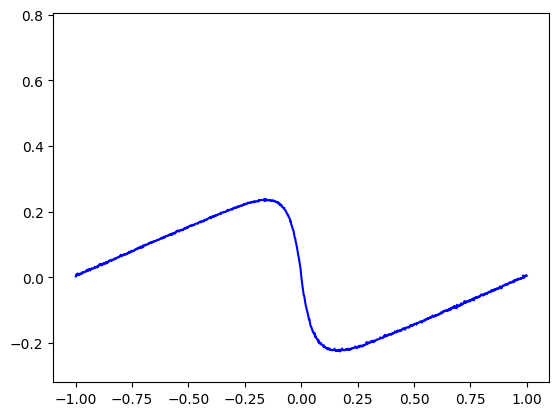

In [ ]:
# Making predictions
with torch.no_grad():
    u = model(a.to(device)).to("cpu")

# Convert the output to numpy array if needed
u = u.cpu().numpy().reshape((201, 1024))

from __future__ import annotations

import argparse
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from tqdm import tqdm


def visualize_burgers(xcrd, data):
    """
    This function animates the Burgers equation

    Args:
    path : path to the desired file
    param: PDE parameter of the data shard to be visualized
    """

#     xcrd = np.load("burgers/data/x_coordinate.npy")
    # print(xcrd.shape)
#     data = np.load(path)
    # Initialize plot
    fig, ax = plt.subplots()

    # Store the plot handle at each time step in the 'ims' list
    ims = []

    for i in tqdm(range(data.shape[0])):
        if i == 0:
            im = ax.plot(xcrd, data[i].squeeze(), animated=True, color="blue")
        else:
            im = ax.plot(
                xcrd, data[i].squeeze(), animated=True, color="blue"
            )  # show an initial one first
        ims.append([im[0]])

    # Animate the plot
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

    writer = animation.PillowWriter(fps=15, bitrate=1800)
    ani.save("burgerCombo.gif", writer=writer)

visualize_burgers(x[:], u)